In this notebook we launch the following pipeline
- comparison of variences between 75_regions dataset and OneBatch dataset
- estimation of the parameters of lipids distributions in OneBatch
- generation of fake brains from the estimated distributions
- applying Random Forest ML algorithm to the generated data
- identifying the most important features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

from copy import copy

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
sns.set_theme()
sns.set_context("paper")
sns.set_palette("Set2")

# Helpful functions

In [3]:
def get_only_four(lipids):
    """Obtain the regions for which exactly four observations for distinct brains are available.
    """
    brains_per_region = lipids.groupby("region")["human"].apply(lambda x: str(sorted(list(x))))
    brains_set = str(sorted(list(set(lipids.human.unique()))))
    only_four = set(brains_per_region[brains_per_region == brains_set].index)
    return only_four


def normalize_slow(dataset):
    """Subtract mean over regions for every molecule in each brain.
    """
    new_dataset = []
    for brain in sorted(dataset.human.unique()):
        existing_values = dataset[dataset["human"] == brain].iloc[:, 2:]
        mean_per_brain = existing_values.mean()
        new_dataset.append(existing_values.values - mean_per_brain.values)

    new_dataset = pd.DataFrame(np.concatenate(new_dataset))
    new_dataset.insert(loc=0, column="human", value=dataset.human.values)
    new_dataset.insert(loc=1, column="region", value=dataset.region.values)
    new_dataset.columns = dataset.columns
    return new_dataset


def normalize(dataset):
    means = dataset.drop(columns=["region"]).groupby("human").mean().reset_index()
    mean_repeated = means.iloc[means.index.repeat(dataset.region.nunique())].reset_index(drop=True)
    dataset.iloc[:, 2:] = dataset.iloc[:, 2:] - mean_repeated.iloc[:, 1:]
    return dataset


def prepare_for_dim_reduction(dataset):
    """Reshape the dataset in such a way that all observation for each brain become a single vector.
    """
    new_dataset = []
    for brain in sorted(dataset.human.unique()):
        existing_values = dataset[dataset["human"] == brain].iloc[:, 2:].values.reshape(1, -1)
        new_dataset.append(existing_values)
    new_dataset = np.concatenate(new_dataset)
    return new_dataset



def check_normalization(dataset):
    for brain in dataset.human.unique():
        if abs(dataset[dataset.human == brain].mean().mean()) > 1e-10:
            print("Unnormalized")
            return
    print("Normalized")
    return

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from utils import get_tr_data

# read the data

In [5]:
use_genes = True

In [6]:
onebatch = pd.read_csv("../data/OneBatch3_FINAL2.csv").sort_values(by=["Donor", "Region"])

h_molecules = pd.read_csv("../data/ours_maria_version/rtmz_H_pos_std_weight_norm_TL_COMBINED.csv", index_col=0)
sz_molecules = pd.read_csv("../data/ours_maria_version/rtmz_SZ_pos_std_weight_norm_TL_COMBINED.csv", index_col=0)

h_molecules.index = h_molecules.index.str.split(".").str[0]

meta = pd.read_csv("../data/ours_maria_version/meta_pos_COMBINED.csv")
meta = meta[["Sample", "Brain_abbr", "Region_detailed"]].set_index("Sample")

sz_molecules = meta.join(sz_molecules, how="inner")
# sz_molecules["region_id"] = sz_molecules.Region_detailed.str.split(" ").str[0].astype(int)

h_molecules = meta.join(h_molecules, how="inner")
# h_molecules["region_id"] = h_molecules.Region_detailed.str.split(" ").str[0].astype(int)

meta_lipids = pd.read_csv("../data/ours_maria_version/TL_combined.csv")
lipid_species_colon_replaced = meta_lipids["Lipid.species"].str.replace(":", " ", regex=False).tolist()
lipids_columns = ["Brain_abbr", "Region_detailed"] + lipid_species_colon_replaced
h_molecules.columns = lipids_columns
sz_molecules.columns = lipids_columns

h_molecules = (
    h_molecules
    .sort_values(by=["Brain_abbr", "Region_detailed"])
    .rename(columns={"Brain_abbr": "human", "Region_detailed": "region"})
    .reset_index(drop=True)
)
sz_molecules = (
    sz_molecules
    .sort_values(by=["Brain_abbr", "Region_detailed"])
    .rename(columns={"Brain_abbr": "human", "Region_detailed": "region"})
)
        
if use_genes:
    h_molecules = (
        get_tr_data(True)
        .reset_index()
        .drop(columns=["batch"])
    )
    sz_molecules = (
        get_tr_data(False)
        .reset_index()
        .drop(columns=["batch"])
    )
    common_columns = list(h_molecules.columns[:2]) + sorted(list(set(h_molecules.columns[2:]) & set(sz_molecules.columns[2:])))    
    h_molecules = h_molecules[common_columns]
    sz_molecules = sz_molecules[common_columns]    

In [7]:
h_molecules.groupby("region")["human"].apply(len)

region
1  Cerebellar Grey Matter                    4
15 1ary Motor (BA4)                          4
16 1ary Auditory (BA41/42)                   4
17 1ary Visual Anterior (BA17a)              4
18 1ary Somatosensory (BA3/1/2)              4
27 2ary/3ary Visual Anterior (BA18/19a)      4
28 2ary Auditory, Wernicke (BA22p)           4
29 Precuneus (BA7m)                          4
30 Premotor Anterior Lateral (BA6a)          4
31 Supramarginal Posterior (BA40p)           4
32 Ventrolateral Prefrontal, Broca (BA44)    4
33 Anterior Inferior Temporal (BA20a)        4
34 Dorsolateral Prefrontal (BA9)             4
37 2ary Auditory Anterior (BA21a)            4
43 Temporopolar (BA38)                       4
46 Prefrontal Medial (BA10m)                 4
47 Cingulate Posterior (BA31)                4
48 Cingulate Anterior (BA24)                 4
49 Cingulate Anterior (BA32)                 4
50 Orbitofrontal (BA11)                      4
52 Amygdala                                  4
53 Ins

In [8]:
vc_h = h_molecules.region.value_counts()
vc_sz = sz_molecules.region.value_counts()


In [9]:
vc = pd.concat([vc_h, vc_sz], axis=1).reset_index()
vc.columns = ["Region", "HC samples", "SZ samples"]
vc.Region = vc.Region.apply(lambda x: " ".join(x.split()[1:]))

In [10]:
# print(", ".join(vc[(vc["HC samples"] == 4) & (vc["SZ samples"] == 4)].Region.tolist()))

In [11]:
# print(vc[(vc["HC samples"] != 4) | (vc["SZ samples"] != 4)].reset_index(drop=True).to_latex(index=False))
# print(vc.reset_index(drop=True).to_latex(index=False))

## Investigate

In [12]:
regions_75_lipids = meta_lipids["Lipid.species"].str.replace(":", " ").unique().tolist()
onebatch_molecules = onebatch.columns[9:].str.replace(".", " ", regex=False).tolist()
common_molecules = list(set(regions_75_lipids) & set(onebatch_molecules))
common_molecules = np.array(common_molecules)
print("Lipids in 75 regions dataset, lipids in onebathc dataset, common lipids:")
print(len(regions_75_lipids), len(onebatch_molecules), len(common_molecules))
duplicates = h_molecules.columns.value_counts()[h_molecules.columns.value_counts() != 1].index
print("\nCommon lipids after removing duplicates:")
common_molecules = list(set(common_molecules) - set(duplicates))
print(len(common_molecules))

h_only_four = get_only_four(h_molecules)
sz_only_four = get_only_four(sz_molecules)
regions_only_four = list(h_only_four & sz_only_four)
print("\nNum of regions for which there are 4 SZ and 4 HC observations")
print(len(regions_only_four))

Lipids in 75 regions dataset, lipids in onebathc dataset, common lipids:
347 445 58

Common lipids after removing duplicates:
58

Num of regions for which there are 4 SZ and 4 HC observations
35


In [13]:
onebatch = onebatch.rename(columns={"Donor": "human"})
onebatch.columns = onebatch.columns.str.replace(".", " ", regex=False)
onebatch_only_common = copy(onebatch[onebatch.columns[:9].tolist() + common_molecules])
onebatch_only_common.iloc[:, 9:] *= np.log10(2)
onebatch_only_common.head()

,Unnamed: 0,Sample,SZ,Type,Region,human,Order,Mass,MassCoef,PC 42 7,...,FA 22 4,PC 37 5,FA 24 5,PC 34 2,FA 18 1,FA 22 0,FA 18 2,LPE 24 4,PC 42 4,LPE 22 4
3,V22,HC10M_f_36_CCp_x2_NEG_068,HC,Sample,BA22,HC10M,68,18.6,-0.048999,6.219815,...,7.258417,5.535829,4.837981,6.484474,7.272514,4.836526,6.255731,4.629900,5.255574,6.640364
1,V20,HC10M_f_36_BA9_x2_NEG_041,HC,Sample,BA9,HC10M,41,16.4,-0.230605,6.068266,...,7.061656,5.122217,4.619936,6.484561,7.049261,4.814705,5.999318,4.413117,4.927128,6.522458
0,V19,HC10M_f_36_BA22p_x2_NEG_093,HC,Sample,CCp,HC10M,93,24.9,0.371845,6.366699,...,7.508276,5.865455,4.962683,5.588093,7.484024,4.528280,5.961067,5.094628,6.263263,6.367051
2,V21,HC10M_f_36_CCa_x2_NEG_092,HC,Sample,Cca,HC10M,92,21.1,0.132942,6.050411,...,7.573149,5.597714,5.145556,5.473230,7.630714,4.543238,6.226076,5.089776,5.984626,6.435581
4,V23,HC16M_f_54_BA22p_x2_NEG_006,HC,Sample,BA22,HC16M,6,14.6,-0.398333,6.003009,...,7.174687,5.426233,4.336064,6.091305,7.127255,4.806948,5.701896,5.245931,5.666279,6.660952


OneBatch is log2 data. 75_regions is log10 data. Therefore, we multiply Onebatch by $\log_{10}(2)$, because $\log_{10}(x) = \log_{10}(2) \times \log_2(x)$

## Normalize (make mean value for each molecule in each brain zero)

In [14]:
dataset = onebatch
new_dataset = []
for brain in dataset.human.unique():
    existing_values = dataset[dataset["human"] == brain].iloc[:, 9:]
    mean_per_brain = existing_values.mean()
    new_dataset.append((existing_values.values - mean_per_brain.values))

new_dataset = pd.DataFrame(np.concatenate(new_dataset))

new_dataset = pd.concat([onebatch.iloc[:, :9], new_dataset], axis=1)
new_dataset.columns = onebatch.columns
onebatch = new_dataset

In [15]:
sz_molecules = sz_molecules[sz_molecules.region.isin(regions_only_four)].reset_index(drop=True)
sz_molecules = normalize(sz_molecules)

In [16]:
h_molecules = h_molecules[h_molecules.region.isin(regions_only_four)].reset_index(drop=True)
h_molecules = normalize(h_molecules)

In [17]:
# Check normalization
check_normalization(sz_molecules)
check_normalization(onebatch)
check_normalization(h_molecules)

Normalized
Unnormalized
Normalized


In [18]:
all_observations_combined_75 = np.concatenate([h_molecules.iloc[:, 2:].values, sz_molecules.iloc[:, 2:].values]).reshape(-1,)

In [19]:
all_observations_combined_75.shape

(3969560,)

In [20]:
all_observations_combined_75

array([-0.33119386, -0.03970154,  0.22564781, ..., -0.38535855,
        0.22234887, -0.11638796])

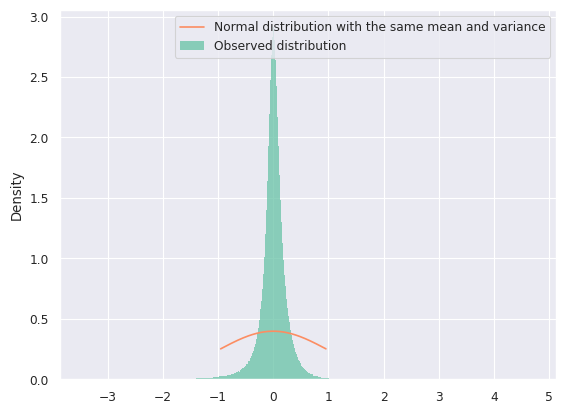

In [21]:
left_point = norm.ppf(0.0001, loc=all_observations_combined_75.mean(), scale=all_observations_combined_75.std())
right_point = norm.ppf(0.9999, loc=all_observations_combined_75.mean(), scale=all_observations_combined_75.std()),
x = np.linspace(left_point, right_point, 1000)
plt.plot(x, norm.pdf(x), c="C1", label="Normal distribution with the same mean and variance")
sns.histplot(all_observations_combined_75, stat="density", label="Observed distribution")
plt.legend()
plt.show()

## Data visualization

### 75_regions (normalized), brain as object

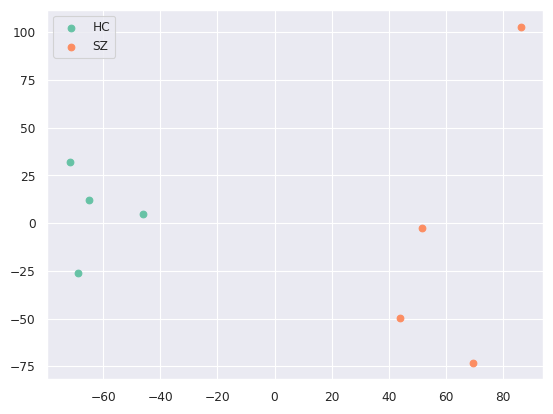

In [22]:
h_molecules_dim_reduction = prepare_for_dim_reduction(h_molecules[h_molecules.region.isin(regions_only_four)])
sz_molecules_dim_reduction = prepare_for_dim_reduction(sz_molecules[sz_molecules.region.isin(regions_only_four)])

dim_reduction = PCA(n_components=2)

lipids_dim_reduction = dim_reduction.fit_transform(np.concatenate([h_molecules_dim_reduction, sz_molecules_dim_reduction]))

plt.scatter(lipids_dim_reduction[:4, 0], lipids_dim_reduction[:4, 1], label="HC")
plt.scatter(lipids_dim_reduction[4:, 0], lipids_dim_reduction[4:, 1], label="SZ")
# plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
# plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
# plt.title(f"75 regions dataset (50 taken)")

plt.legend()
plt.savefig(f"../data/pics/{'genes' if use_genes else 'lipids'}_brain_as_object_real.png", dpi=200)
plt.show()

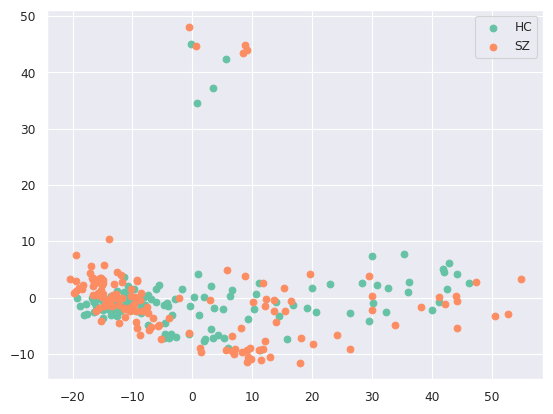

In [23]:
h_molecules_dim_reduction = h_molecules[h_molecules.region.isin(regions_only_four)].iloc[:, 2:]
sz_molecules_dim_reduction = sz_molecules[sz_molecules.region.isin(regions_only_four)].iloc[:, 2:]

dim_reduction = PCA(n_components=2)

lipids_dim_reduction = dim_reduction.fit_transform(np.concatenate([h_molecules_dim_reduction, sz_molecules_dim_reduction]))

border = lipids_dim_reduction.shape[0] // 2

plt.scatter(lipids_dim_reduction[:border, 0], lipids_dim_reduction[:border, 1], label="HC")
plt.scatter(lipids_dim_reduction[border:, 0], lipids_dim_reduction[border:, 1], label="SZ")
# plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
# plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
# plt.title(f"75 regions dataset (50 taken)")

plt.legend()
plt.savefig(f"../data/pics/{'genes' if use_genes else 'lipids'}_region_as_object_real.png", dpi=200)
plt.show()

### One batch (normalized), brain as object

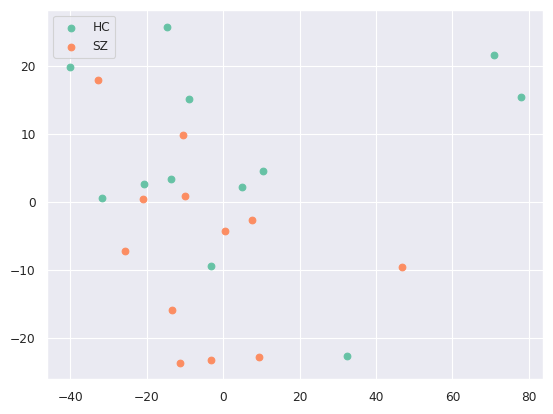

In [24]:
new_onebatch = []
for brain in onebatch.human.unique():
    existing_values = onebatch[onebatch["human"] == brain].iloc[:, 9:].values.reshape(1, -1)
    new_onebatch.append(existing_values)
new_onebatch = np.concatenate(new_onebatch)

dim_reduction = PCA(n_components=2)

dim_reduction_fitted = dim_reduction.fit_transform(new_onebatch)

plt.scatter(dim_reduction_fitted[:12, 0], dim_reduction_fitted[:12, 1], label="HC")
plt.scatter(dim_reduction_fitted[12:, 0], dim_reduction_fitted[12:, 1], label="SZ")
plt.legend()
plt.show()

## Example lipid profile

In [25]:
if not use_genes:
    sns.lineplot(h_molecules[h_molecules["human"] == "HA"].loc[:, h_molecules.columns.str.contains("FA")])
    plt.ylim(-6, 10)
    plt.title("All Fatty Acid profiles in one of the brains")
    plt.legend(ncols=4)
    plt.savefig("../data/pics/example_profiles.pdf")

- BA9: 35 Dorsolateral Prefrontal Medial (BA9m), 34 Dorsolateral Prefrontal (BA9)
- BA22: 26 2ary Auditory, language (BA22a), 28 2ary Auditory, Wernicke (BA22p)

In [26]:
# region_translate = {
#     "CCp": '74 Corpus Callosum Posterior',
#     "BA9": "34 Dorsolateral Prefrontal (BA9)",
#     "Cca": '73 Corpus Callosum Anterior',
#     "BA22": "28 2ary Auditory, Wernicke (BA22p)",
# }

region_translate = {
    '74 Corpus Callosum Posterior': "CCp",
    "34 Dorsolateral Prefrontal (BA9)": "BA9",
    '73 Corpus Callosum Anterior': "Cca",
    "28 2ary Auditory, Wernicke (BA22p)": "BA22",
}

# Generate fake dataset

## Prepare the labels

In [27]:
N_SAMPLES = 100 if use_genes else 1000 
# for each class SZ and SZ
# 100 for lipids is too few
# 1000 for genes makes the kernel die
# 10000 for lipids makes the kernel die


brains_labels_hc = [f"HC{i + 1}" for i in range(N_SAMPLES)] * len(regions_only_four)
brains_labels_sz = [f"SZ{i + 1}" for i in range(N_SAMPLES)] * len(regions_only_four)
brains_labels = np.array(brains_labels_hc + brains_labels_sz)

regions_labels = np.concatenate([np.array([region] * N_SAMPLES) for region in regions_only_four])
regions_labels = np.concatenate([regions_labels, regions_labels])

## Sampling

In [28]:
if use_genes:
    common_molecules = np.array(h_molecules.columns[2:].tolist())
else:
    vc = pd.Series(h_molecules.columns[2:]).value_counts()
    common_molecules = vc[vc == 1].index.tolist()

In [29]:
fake_dataset = []
fake_dataset_75 = []
std_comparison = []

hc_column = []
region_nm_column = []

for human_type in ["HC", "SZ"]:
    for region_nm in regions_only_four:
        
        # First, we generate the data based on 75_regions (taking 50 of them)
        # In this loop we generate N_SAMPLES individuals for each region_nm
        if human_type == "HC":
            regions_75_lipids = h_molecules[h_molecules["region"] == region_nm][common_molecules]
        else:
            regions_75_lipids = sz_molecules[sz_molecules["region"] == region_nm][common_molecules]

        generated_75 = np.random.normal(
            loc=regions_75_lipids.mean(), scale=regions_75_lipids.std(), size=(N_SAMPLES, len(common_molecules))
        )
        fake_dataset_75.append(generated_75)
        
        # Second, we generate the data based on OneBatch
#         if not use_genes:
#             if region_nm in region_translate:
#                 to_plot = onebatch_only_common[
#                     (onebatch_only_common.SZ == human_type) 
#                     & (onebatch_only_common.Region == region_translate[region_nm])
#                 ]
#                 onebatch_molecules = to_plot[common_molecules]

#                 # We save the mean fold-difference between variances
#                 std_comparison.append(
#                     [human_type, region_nm, (regions_75_lipids.var() / onebatch_molecules.var()).mean()]
#                 )

#                 generated = np.random.normal(
#                     loc=onebatch_molecules.mean(), scale=onebatch_molecules.std(), size=(N_SAMPLES, len(common_molecules))
#                 )
#                 fake_dataset.append(generated)

In [30]:
# print("Standard deviation comparison, 75 divide by onebatch")
# pd.DataFrame(np.array(std_comparison), columns=["SZ", "region", "mean fold-change"])

## Normalize

In [31]:
fake_dataset_75 = pd.DataFrame(np.concatenate(fake_dataset_75))
    

In [32]:
fake_dataset_75.insert(0, "human", brains_labels)

In [33]:
fake_dataset_75.insert(1, "region", regions_labels)
fake_dataset_75 = fake_dataset_75.sort_values(by=["human", "region"])
fake_dataset_75 = normalize(fake_dataset_75)
# check_normalization(fake_dataset_75)

In [34]:
# fake_dataset_75.to_csv("../data/to_normalize/fake_dataset_75.csv", index=None)

# Now you must execute ./normalize.py ../data/to_normalize/fake_dataset_75.csv

# fake_dataset_75_normalized = pd.read_csv("../data/to_normalize/fake_dataset_75_normalized.csv")

In [35]:
fake_dataset_75.head()

,human,region,0,1,2,3,4,5,6,7,...,14167,14168,14169,14170,14171,14172,14173,14174,14175,14176
100,HC1,1 Cerebellar Grey Matter,-0.037698,-0.010649,0.176352,0.285609,-0.094256,-0.178571,-0.287203,-0.198786,...,1.322768,0.221017,-1.057745,-0.251455,-0.196477,-0.280805,-0.621037,0.195510,-0.375003,-0.048085
600,HC1,15 1ary Motor (BA4),-0.426097,-0.044475,-0.055471,0.050353,0.053122,-0.201770,-0.011539,-0.025544,...,-0.136521,-0.008161,0.080811,0.804801,0.359058,0.494292,-0.131432,0.192751,0.398988,0.124403
1000,HC1,16 1ary Auditory (BA41/42),-0.895576,0.026246,-0.122641,-0.064093,0.151654,-0.129899,-0.029164,0.012658,...,-0.195332,0.045030,-0.065205,-0.617080,-0.037194,1.084546,0.122761,-0.228213,0.057733,0.563484
1900,HC1,17 1ary Visual Anterior (BA17a),-0.139748,-0.058677,0.037892,-0.055781,-0.267894,0.081073,-0.238367,-0.188169,...,0.890670,0.062651,0.462929,-0.264278,0.108055,0.702541,1.005390,0.163447,0.124246,-0.135866
2000,HC1,18 1ary Somatosensory (BA3/1/2),0.391075,-0.063929,-0.055294,0.350292,-0.052095,-0.521547,-0.106466,0.096598,...,1.116170,-0.034027,-0.320868,-1.194609,-0.101099,-1.076620,-0.947130,-0.289876,0.448579,0.074630


In [36]:
fake_dataset_75.shape

(7000, 14179)

In [37]:
fake_dataset_75_reduction = prepare_for_dim_reduction(fake_dataset_75)
fake_dataset_75_reduction.shape

(200, 496195)

## Plot fake dataset (normalized)

### brain as object

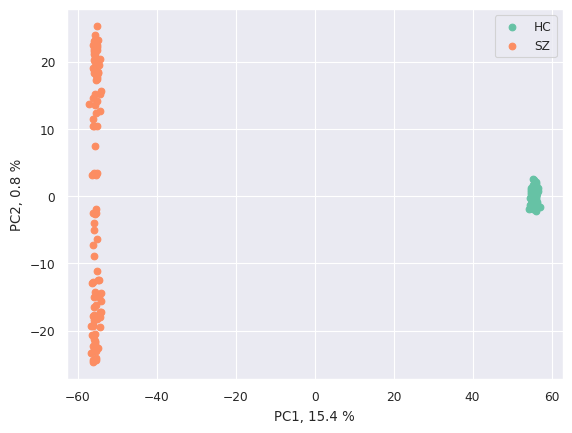

In [38]:
dim_reduction = PCA(n_components=2)
fake_dataset_dim_reduction = dim_reduction.fit_transform(fake_dataset_75_reduction)
plt.scatter(fake_dataset_dim_reduction[:N_SAMPLES, 0], fake_dataset_dim_reduction[:N_SAMPLES, 1], label="HC")
plt.scatter(fake_dataset_dim_reduction[N_SAMPLES:, 0], fake_dataset_dim_reduction[N_SAMPLES:, 1], label="SZ")
plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
# plt.title(f"n={N_SAMPLES} for each class")
plt.legend()
plt.savefig(f"../data/pics/{'genes' if use_genes else 'lipids'}_brain_as_object_75_gen.png", dpi=200)

### region as object

In [39]:
fake_dataset_75.shape

(7000, 14179)

In [40]:
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding


In [41]:
from sklearn.decomposition import KernelPCA, TruncatedSVD

In [42]:
use_PCA = True
if use_PCA:
    dim_reduction = PCA(n_components=2)
else:
    dim_reduction = Isomap(n_components=2)
    
fake_dataset_dim_reduction = dim_reduction.fit_transform(fake_dataset_75.iloc[:, 2:])

In [43]:
border = fake_dataset_dim_reduction.shape[0] // 2

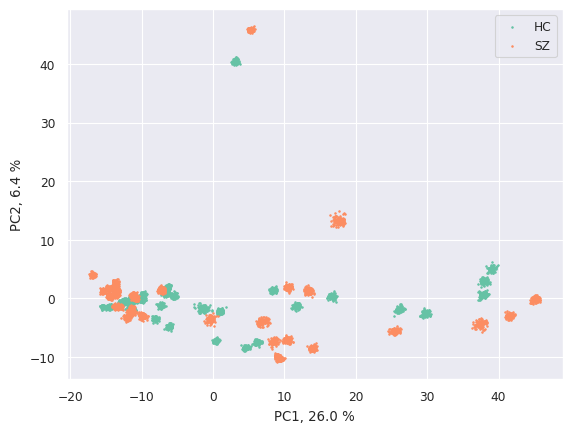

In [44]:
plt.scatter(
    fake_dataset_dim_reduction[:border, 0],
    fake_dataset_dim_reduction[:border, 1],
    label="HC", s=1
)
plt.scatter(
    fake_dataset_dim_reduction[border:, 0],
    fake_dataset_dim_reduction[border:, 1],
    label="SZ", s=1
)
if use_PCA:
    plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
    plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
# plt.title(f"Each point is a region\nn={N_SAMPLES} for each class\ndataset is normalized\nno variance added")
plt.legend()
plt.savefig(f"../data/pics/{'genes' if use_genes else 'lipids'}_region_as_object_75_gen_{'PCA' if use_PCA else 'tsne'}.png", dpi=200)

## Plot lipids

In [45]:
# fig, axs = plt.subplots(ncols=5, nrows=5, figsize=(5*6, 5*4))
# axs = axs.flatten()
# for i in range(25):
#     sns.histplot(to_plot.iloc[:, i + 9], kde=True, stat="density", ax=axs[i])
#     sns.rugplot(to_plot.iloc[:, i + 9], ax=axs[i], height=0.1, linewidth=2)
#     axs[i].set_xlabel("")
#     axs[i].set_ylabel("")
# plt.savefig("../data/pics/lipids_distr.png", bbox_inches='tight')

# Training

## brain as object

In [46]:
half_len = len(fake_dataset_75) // 2
num_people = fake_dataset_75.human.nunique() // 2
hc_fake = fake_dataset_75.iloc[:half_len, 2:].values.reshape(num_people, -1)
sz_fake = fake_dataset_75.iloc[half_len:, 2:].values.reshape(num_people, -1)
train_dataset = np.vstack([hc_fake, sz_fake])
y = np.ones(2 * N_SAMPLES)
y[:N_SAMPLES] = 0

In [47]:
train_dataset.shape

(200, 496195)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train_dataset, y, test_size=0.2, shuffle=True, random_state=435132)

### Random Forest

In [49]:
rf = RandomForestClassifier(criterion='gini', random_state=3643216)

In [50]:
rf.fit(X_train, y_train)
accuracy_score(rf.predict(X_test), y_test)

1.0

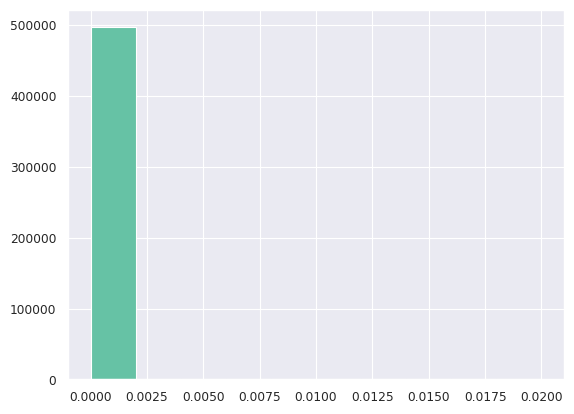

In [51]:
plt.hist(rf.feature_importances_)
plt.show()

In [52]:
feature_names = []
for region_nm in regions_only_four:
    feature_names += ((region_nm + "_") + pd.Series(common_molecules)).values.tolist()
feature_names = np.array(feature_names)

print(feature_names[rf.feature_importances_.argsort()[:-5:-1]])

['53 Insular Posterior Cortex_ENSG00000162882'
 '64 Globus Pallidus_ENSG00000178096'
 '63 Substantia Nigra_ENSG00000284308'
 '55 Hippocampus, CA3 / Dentate Gyrus_ENSG00000138193']


In [53]:
importances_df = pd.DataFrame(np.vstack([feature_names, rf.feature_importances_]).T, columns=["feature name", "importance"])

importances_df = importances_df.sort_values(by="importance", ascending=False).reset_index(drop=True)

importances_df.to_csv(f"../data/importances/{'genes' if use_genes else 'lipids'}_brain_rf.csv")

### Logreg + permutation

In [54]:
X_train = np.array(X_train)

In [55]:
scaler = StandardScaler()

In [56]:
X_train_scaled = scaler.fit_transform(X_train)

In [57]:
X_train.shape

(160, 496195)

In [58]:
clf = LogisticRegression(solver='lbfgs', random_state=9843595, n_jobs=-1).fit(X_train_scaled, y_train)

In [59]:
result = permutation_importance(clf, X_train_scaled, y_train, n_repeats=5, 
                                random_state=234325, n_jobs=-1)

Process LokyProcess-1:
Process LokyProcess-2:
Traceback (most recent call last):
  File "/home/zybinmikhail/anaconda3/envs/thesis/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/zybinmikhail/anaconda3/envs/thesis/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zybinmikhail/anaconda3/envs/thesis/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 474, in _process_worker
    with worker_exit_lock:
  File "/home/zybinmikhail/anaconda3/envs/thesis/lib/python3.10/site-packages/joblib/externals/loky/backend/synchronize.py", line 110, in __enter__
    return self._semlock.acquire()
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/zybinmikhail/anaconda3/envs/thesis/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/zybinmikhail/anaconda3/envs/thesis/lib/python3.10/multiprocessing/proce

Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x7f0f7c3b83a0>> (for post_execute):



KeyboardInterrupt



## Region as object

In [60]:
fake_dataset_75.head()

,human,region,0,1,2,3,4,5,6,7,...,14167,14168,14169,14170,14171,14172,14173,14174,14175,14176
100,HC1,1 Cerebellar Grey Matter,-0.037698,-0.010649,0.176352,0.285609,-0.094256,-0.178571,-0.287203,-0.198786,...,1.322768,0.221017,-1.057745,-0.251455,-0.196477,-0.280805,-0.621037,0.195510,-0.375003,-0.048085
600,HC1,15 1ary Motor (BA4),-0.426097,-0.044475,-0.055471,0.050353,0.053122,-0.201770,-0.011539,-0.025544,...,-0.136521,-0.008161,0.080811,0.804801,0.359058,0.494292,-0.131432,0.192751,0.398988,0.124403
1000,HC1,16 1ary Auditory (BA41/42),-0.895576,0.026246,-0.122641,-0.064093,0.151654,-0.129899,-0.029164,0.012658,...,-0.195332,0.045030,-0.065205,-0.617080,-0.037194,1.084546,0.122761,-0.228213,0.057733,0.563484
1900,HC1,17 1ary Visual Anterior (BA17a),-0.139748,-0.058677,0.037892,-0.055781,-0.267894,0.081073,-0.238367,-0.188169,...,0.890670,0.062651,0.462929,-0.264278,0.108055,0.702541,1.005390,0.163447,0.124246,-0.135866
2000,HC1,18 1ary Somatosensory (BA3/1/2),0.391075,-0.063929,-0.055294,0.350292,-0.052095,-0.521547,-0.106466,0.096598,...,1.116170,-0.034027,-0.320868,-1.194609,-0.101099,-1.076620,-0.947130,-0.289876,0.448579,0.074630


In [61]:
train_dataset = fake_dataset_75.iloc[:, 2:]
y = np.ones(fake_dataset_75.shape[0])
y[:fake_dataset_75.shape[0] // 2] = 0
X_train, X_test, y_train, y_test, regions_train, regions_test = (
    train_test_split(
        train_dataset, y, fake_dataset_75.region,
        test_size=0.2, shuffle=True, random_state=435132
    )
)

### Random Forest

In [62]:
rf = RandomForestClassifier(random_state=3643216).fit(X_train, y_train)

In [63]:
y_pred = rf.predict(X_test)

In [64]:
correst_classification = (y_pred == y_test)

In [65]:
clf_res = pd.concat([regions_test.reset_index(drop=True), pd.Series(correst_classification)], axis=1)
clf_res = clf_res.groupby("region")[0].apply(np.mean)
clf_res.index = clf_res.index.str.split().str[1:].str.join(" ")
clf_res = pd.DataFrame(clf_res).reset_index()
clf_res.columns = ["Region", "accuracy"]
clf_res = clf_res.sort_values(by="accuracy").reset_index(drop=True)

In [66]:
print(clf_res.iloc[:5, :].to_latex(index=False))

\begin{tabular}{lr}
\toprule
                  Region &  accuracy \\
\midrule
  Cerebellar Grey Matter &       1.0 \\
    Orbitofrontal (BA11) &       1.0 \\
                Amygdala &       1.0 \\
Insular Posterior Cortex &       1.0 \\
       Entorhinal Cortex &       1.0 \\
\bottomrule
\end{tabular}



In [67]:
print(clf_res.iloc[-5:, :].to_latex(index=False))

\begin{tabular}{lr}
\toprule
                          Region &  accuracy \\
\midrule
   Dorsolateral Prefrontal (BA9) &       1.0 \\
  2ary Auditory Anterior (BA21a) &       1.0 \\
             Temporopolar (BA38) &       1.0 \\
Premotor Anterior Lateral (BA6a) &       1.0 \\
         Cerebellar White Matter &       1.0 \\
\bottomrule
\end{tabular}



In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [ ]:
X_train, y_train = shuffle(train_dataset, y, random_state=239875)

In [ ]:
cv = cross_val_score(RandomForestClassifier(random_state=3643216), X_train, y_train, cv=5, n_jobs=-1)

In [ ]:
cv.mean()

In [ ]:
plt.hist(rf.feature_importances_)
plt.show()

In [ ]:
X_train.shape

In [ ]:
print(pd.DataFrame(common_molecules[rf.feature_importances_.argsort()][:-6:-1]).to_latex())

In [ ]:
print(", ".join(common_molecules[rf.feature_importances_.argsort()][:-6:-1].tolist()))

In [69]:
importances_df = pd.DataFrame(np.vstack([np.array(common_molecules), rf.feature_importances_]).T, columns=["feature name", "importance"])

importances_df = importances_df.sort_values(by="importance", ascending=False).reset_index(drop=True)

importances_df.to_csv(f"../data/importances/{'genes' if use_genes else 'lipids'}_regions_rf.csv")

### Logreg + permutations (not suitable for genes, too slow)

In [70]:
X_train = np.array(X_train)

In [71]:
scaler = StandardScaler()

In [72]:
X_train_scaled = scaler.fit_transform(X_train)

In [73]:
X_train.shape

(5600, 14177)

In [75]:
clf = LogisticRegression(solver='lbfgs', random_state=9843595, n_jobs=-1).fit(X_train_scaled, y_train)

In [ ]:
result = permutation_importance(clf, X_train_scaled, y_train, n_repeats=5, 
                                random_state=234325, n_jobs=-1)

In [ ]:
print(", ".join(common_molecules[result.importances_mean.argsort()][:-6:-1].tolist()))

## GNN approach (only if brain is treated as object)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [ ]:
coord = pd.read_csv("../data/75_regions_coord.txt", sep="\t")
# display(coord.head())
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(coord.x, coord.y, coord.z)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(18900, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
full_graph = [[[i, j] for i in range(50)] for j in range(50)]
full_graph = torch.tensor(np.concatenate(full_graph).T)

data_list = []
for human in ["H1", "H2", "H3", "H5"]:
    lipid_profiles = sz_molecules[sz_molecules.human == human].iloc[:, 2:-1].values.reshape(1,-1)
    lipid_profiles = torch.Tensor(lipid_profiles)
    print(lipid_profiles.shape)
    data = Data(
        x=lipid_profiles,
        edge_index=full_graph,
#         pos=coord[["x", "y", "z"]],
        y=1,
    )
    data_list.append(data)

for human in ["HA", "HB", "HC", "HD"]:
    lipid_profiles = h_molecules[h_molecules.human == human].iloc[:, 2:-1].values.reshape(1,-1)
    lipid_profiles = torch.Tensor(lipid_profiles)
    data = Data(
        x=lipid_profiles,
        edge_index=full_graph,
#         pos=coord[["x", "y", "z"]],
        y=0,
    )
    print(lipid_profiles.shape)
    data_list.append(data)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
data_list

In [ ]:
loader = DataLoader(data_list, batch_size=1, shuffle=True)

In [ ]:
model(data_list[0])

In [ ]:
next(iter(loader))

In [ ]:
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    data = next(iter(loader)).to(device)    
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()